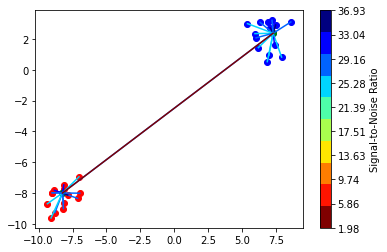

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import syft as sy
import numpy as np
from Dataset import load_dataset, getImage
from utils import averageModels
from utils import averageModelscluster
import random
import math
import matplotlib.pyplot as plt
from modifying_KMeans_snr import cluster_former
import copy

In [2]:
P=2 #signal power threshold
#stream = BitStream()
#random.seed(10)
key=[]
for i in range (10000): #generating a random password to activate training (Pilot signal)
    temp=random.randint(0,1)
    key.append(temp)

key1=[0]*len(key)
for i in range (len(key)):   #bpsk modulation
    if(key[i]==1):
        #print("yay")
        key1[i]=-math.sqrt(P)
    else:
        key1[i]=math.sqrt(P)

#print(key)
        
key_np=np.array(key1)

In [3]:
class Arguments():
    def __init__(self):
        self.images = 10000
        self.clients = 30
        self.rounds = 200
        self.epochs = 10
        self.local_batches = 64
        self.lr = 0.001
        self.C = 1 #fraction of clients used in the round
        self.drop_rate = 0 #fraction of devices in the selected set to be dropped for various reasons
        self.torch_seed = 0 #same weights and parameters whenever the program is run
        self.log_interval = 64
        self.iid = 'noniid'
        self.split_size = int(self.images / self.clients)
        self.samples = self.split_size / self.images 
        self.use_cuda = False
        self.save_model = True
        self.csi_low=0
        self.csi_high=1

args = Arguments()

In [4]:
#checking if gpu is available
#use_cuda = args.use_cuda and torch.cuda.is_available()
use_cuda=False
device = torch.device("cuda:0" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

hook = sy.TorchHook(torch)
me = hook.local_worker
clients = []

#generating virtual clients
for i in range(args.clients):
    clients.append({'hook': sy.VirtualWorker(hook, id="client{}".format(i+1))})
#print(clients)

In [5]:
global_train, global_test, train_group, test_group = load_dataset(args.clients, args.iid) #load data

for inx, client in enumerate(clients):  #return actual image set for each client
    trainset_ind_list = list(train_group[inx]) 
    client['trainset'] = getImage(global_train, trainset_ind_list, args.local_batches)
    client['testset'] = getImage(global_test, list(test_group[inx]), args.local_batches)
    client['samples'] = len(trainset_ind_list) / args.images #useful while taking weighted average


/home/iiitd/anaconda3/envs/FL/lib/python3.8/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [6]:
#load dataset for global model (to compare accuracies)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
global_test_dataset = datasets.MNIST('./', train=True, download=True, transform=transform)
global_test_dataset = torch.utils.data.random_split(global_test_dataset, [10000, len(global_test_dataset)-10000])[0]
global_test_loader = DataLoader(global_test_dataset, batch_size=args.local_batches, shuffle=True)

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #self.quant = torch.quantization.QuantStub()
        self.conv1 = nn.Conv2d(1, 5, 5, 1)
        self.conv2 = nn.Conv2d(5, 10, 5, 1)
        self.fc1 = nn.Linear(4*4*10, 2048) #10 iid #50 non iid
        self.fc2 = nn.Linear(2048, 10)

    def forward(self, x):
        #x=self.quant(x)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*10
                   )
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [8]:
def ClientUpdate(args, device, client,key_np,key,snr,csi,mu):
    gc=False
    client['model'].train()
    #simulating a wireless channel
    poptim=max((1/mu-1/csi),0)
    #print(mu,csi)
    print("Power Allocated=",poptim)
    print("CSI=",csi)
    
    snr__=10**(snr/10)
    
    absh=csi*poptim/snr__
    x=random.uniform(0,absh)
    #print(x)
    y=math.sqrt(absh*absh-x*x)
    #x=x*100
    #y=y*100
    #x=random.random()
    #y=random.random()
    #snr=10*math.log(poptim/(std*std),10)
    std=math.sqrt(poptim/snr__*absh*absh) #channel noise
    
    #print(x,y)
    h=complex(x,y)
    #std=math.sqrt(abs(h)/csi)
    #snr=poptim/(std*std)
    #print(std)
    print("SNR=",snr)
    #print("csi",abs(h)/(std*std))
    
    
    if(poptim!=0):
        data=client['model'].conv1.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data

    
    #print(client['model'].conv1.weight.size)
    client['model'].send(client['hook'])
    print("Client:",client['hook'].id)
    
    key_np_received=h*key_np+(np.random.randn(len(key_np))*std*2)
    #print(key_np_received)
    key_np_received=(key_np_received/(h)).real
    
    for o in range (len(key_np_received)):  #demodulation bpsk
        if(key_np_received[o]>=0):
            key_np_received[o]=0
        else:
            key_np_received[o]=1
    
    key_np_received=key_np_received.tolist()
    key_np_received = [int(item) for item in key_np_received]
    #key_np=key_np.tolist()
    
    
    if(sum(np.bitwise_xor(key,key_np_received))/len(key)==0 and poptim>0): #...............................................checking if channel is good enough for transmission by checking BER..................................#
        gc=True #considering the client model for training
        for epoch in range(1, args.epochs + 1):
            for batch_idx, (data, target) in enumerate(client['trainset']): 
                data = data.send(client['hook'])
                target = target.send(client['hook'])
                
                #train model on client
                data, target = data.to(device), target.to(device) #send data to cpu/gpu (data is stored locally)
                output = client['model'](data)
                loss = F.nll_loss(output, target)
                loss.backward()
                client['optim'].step()
                
                if batch_idx % args.log_interval == 0:
                    loss = loss.get() 
                    print('Model {} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        client['hook'].id,
                        epoch, batch_idx * args.local_batches, len(client['trainset']) * args.local_batches, 
                        100. * batch_idx / len(client['trainset']), loss))
    else:
        print("Poor Channel, client not taken for averaging in this round")
            
                    
    client['model'].get()
    # print()
         #CHANGE
    if(poptim!=0):
        data=client['model'].conv1.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data
    #CHANGE ENDS
    print()
    return gc

In [9]:
def test(args, model, device, test_loader, name,fed_round):
    model.eval()    #no need to train the model while testing
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if(use_cuda and fed_round==0):
                data,target=data.cuda(),target.cuda()
                #model.cuda()
            else:
                data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss for {} model: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        name, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return(100. * correct / len(test_loader.dataset))

In [10]:
torch.manual_seed(args.torch_seed)

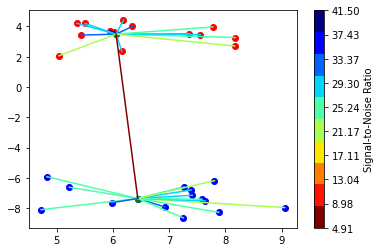

14
14

Power Allocated= 3.2233257655586307
CSI= 0.9659453314730677
SNR= 31.474765549541488
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.321961
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 2.023942


/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  to_return = self.native_grad


Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 1.249448
Model client4 Train Epoch: 4 [0/320 (0%)]	Loss: 0.691690
Model client4 Train Epoch: 5 [0/320 (0%)]	Loss: 0.765871
Model client4 Train Epoch: 6 [0/320 (0%)]	Loss: 0.935511
Model client4 Train Epoch: 7 [0/320 (0%)]	Loss: 0.491607
Model client4 Train Epoch: 8 [0/320 (0%)]	Loss: 0.794497
Model client4 Train Epoch: 9 [0/320 (0%)]	Loss: 0.419534
Model client4 Train Epoch: 10 [0/320 (0%)]	Loss: 0.343396

Power Allocated= 2.603628087889576
CSI= 0.6042467843226621
SNR= 41.4970229940401
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.252655
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 2.120893
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.748373
Model client5 Train Epoch: 4 [0/320 (0%)]	Loss: 1.187506
Model client5 Train Epoch: 5 [0/320 (0%)]	Loss: 0.864087
Model client5 Train Epoch: 6 [0/320 (0%)]	Loss: 0.659651
Model client5 Train Epoch: 7 [0/320 (0%)]	Loss: 0.394207
Model client5 Train Epoch: 8 [0/320 (0%)]	Loss

/tmp/ipykernel_551986/3032248498.py:65: RuntimeWarning: invalid value encountered in true_divide
  key_np_received=(key_np_received/(h)).real


Model client24 Train Epoch: 3 [0/320 (0%)]	Loss: 1.888209
Model client24 Train Epoch: 4 [0/320 (0%)]	Loss: 1.609469
Model client24 Train Epoch: 5 [0/320 (0%)]	Loss: 1.527784
Model client24 Train Epoch: 6 [0/320 (0%)]	Loss: 1.199819
Model client24 Train Epoch: 7 [0/320 (0%)]	Loss: 0.937107
Model client24 Train Epoch: 8 [0/320 (0%)]	Loss: 0.715988
Model client24 Train Epoch: 9 [0/320 (0%)]	Loss: 0.726490
Model client24 Train Epoch: 10 [0/320 (0%)]	Loss: 0.464661

Power Allocated= 2.7749329453330316
CSI= 0.6740142780871754
SNR= 24.36146760810835
Client: client25
Model client25 Train Epoch: 1 [0/320 (0%)]	Loss: 2.213040
Model client25 Train Epoch: 2 [0/320 (0%)]	Loss: 1.996336
Model client25 Train Epoch: 3 [0/320 (0%)]	Loss: 1.392776
Model client25 Train Epoch: 4 [0/320 (0%)]	Loss: 0.702181
Model client25 Train Epoch: 5 [0/320 (0%)]	Loss: 0.549625
Model client25 Train Epoch: 6 [0/320 (0%)]	Loss: 0.259120
Model client25 Train Epoch: 7 [0/320 (0%)]	Loss: 0.278435
Model client25 Train Epoch: 

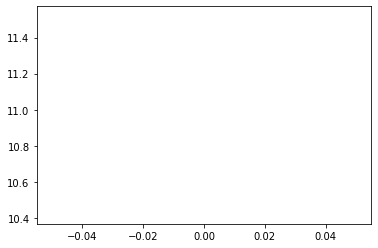

14
14

Power Allocated= 3.2233257655586307
CSI= 0.9659453314730677
SNR= 31.474765549541488
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.267058
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 1.843881
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 1.348500
Model client4 Train Epoch: 4 [0/320 (0%)]	Loss: 0.620771
Model client4 Train Epoch: 5 [0/320 (0%)]	Loss: 0.851233
Model client4 Train Epoch: 6 [0/320 (0%)]	Loss: 0.717492
Model client4 Train Epoch: 7 [0/320 (0%)]	Loss: 0.339916
Model client4 Train Epoch: 8 [0/320 (0%)]	Loss: 0.723466
Model client4 Train Epoch: 9 [0/320 (0%)]	Loss: 0.703873
Model client4 Train Epoch: 10 [0/320 (0%)]	Loss: 0.290163

Power Allocated= 2.603628087889576
CSI= 0.6042467843226621
SNR= 41.4970229940401
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.258204
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 1.664221
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.011768
Model client5 Train Epoch: 4 [0/320 (0%)]	Loss: 0.900

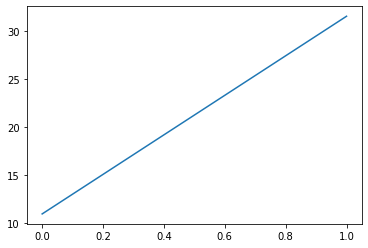

14
14

Power Allocated= 3.2233257655586307
CSI= 0.9659453314730677
SNR= 31.474765549541488
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.256830
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 1.735244
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 1.135786
Model client4 Train Epoch: 4 [0/320 (0%)]	Loss: 0.578796
Model client4 Train Epoch: 5 [0/320 (0%)]	Loss: 0.793015
Model client4 Train Epoch: 6 [0/320 (0%)]	Loss: 0.375026
Model client4 Train Epoch: 7 [0/320 (0%)]	Loss: 0.229442
Model client4 Train Epoch: 8 [0/320 (0%)]	Loss: 0.667244
Model client4 Train Epoch: 9 [0/320 (0%)]	Loss: 0.114277
Model client4 Train Epoch: 10 [0/320 (0%)]	Loss: 0.167160

Power Allocated= 2.603628087889576
CSI= 0.6042467843226621
SNR= 41.4970229940401
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.224405
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 1.684500
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.839631
Model client5 Train Epoch: 4 [0/320 (0%)]	Loss: 0.377

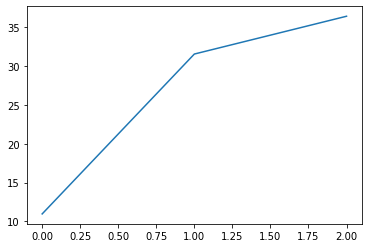

14
14

Power Allocated= 3.2233257655586307
CSI= 0.9659453314730677
SNR= 31.474765549541488
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.278186
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 2.019811
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 1.690436
Model client4 Train Epoch: 4 [0/320 (0%)]	Loss: 0.938706
Model client4 Train Epoch: 5 [0/320 (0%)]	Loss: 0.455531
Model client4 Train Epoch: 6 [0/320 (0%)]	Loss: 0.510427
Model client4 Train Epoch: 7 [0/320 (0%)]	Loss: 0.549300
Model client4 Train Epoch: 8 [0/320 (0%)]	Loss: 0.508648
Model client4 Train Epoch: 9 [0/320 (0%)]	Loss: 0.276754
Model client4 Train Epoch: 10 [0/320 (0%)]	Loss: 0.801688

Power Allocated= 2.603628087889576
CSI= 0.6042467843226621
SNR= 41.4970229940401
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.255517
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 1.780832
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.132021
Model client5 Train Epoch: 4 [0/320 (0%)]	Loss: 0.864

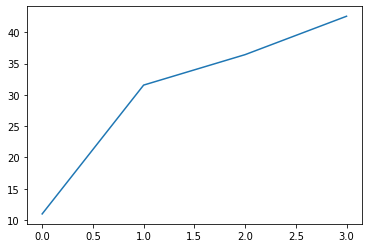

14
14

Power Allocated= 3.2233257655586307
CSI= 0.9659453314730677
SNR= 31.474765549541488
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.281570
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 1.916596
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 1.151302
Model client4 Train Epoch: 4 [0/320 (0%)]	Loss: 0.335300
Model client4 Train Epoch: 5 [0/320 (0%)]	Loss: 0.150168
Model client4 Train Epoch: 6 [0/320 (0%)]	Loss: 0.009720
Model client4 Train Epoch: 7 [0/320 (0%)]	Loss: 0.167950
Model client4 Train Epoch: 8 [0/320 (0%)]	Loss: 0.158348
Model client4 Train Epoch: 9 [0/320 (0%)]	Loss: 0.485987
Model client4 Train Epoch: 10 [0/320 (0%)]	Loss: 0.269625

Power Allocated= 2.603628087889576
CSI= 0.6042467843226621
SNR= 41.4970229940401
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.254692
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 2.013145
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.570187
Model client5 Train Epoch: 4 [0/320 (0%)]	Loss: 0.904

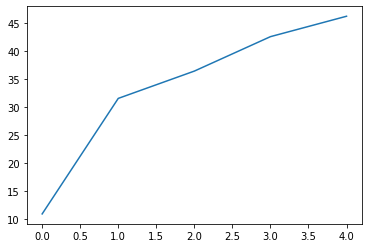

14
14

Power Allocated= 3.2233257655586307
CSI= 0.9659453314730677
SNR= 31.474765549541488
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.234823
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 1.242574
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.512095
Model client4 Train Epoch: 4 [0/320 (0%)]	Loss: 0.852250
Model client4 Train Epoch: 5 [0/320 (0%)]	Loss: 0.263418
Model client4 Train Epoch: 6 [0/320 (0%)]	Loss: 0.248572
Model client4 Train Epoch: 7 [0/320 (0%)]	Loss: 0.479540
Model client4 Train Epoch: 8 [0/320 (0%)]	Loss: 0.087105
Model client4 Train Epoch: 9 [0/320 (0%)]	Loss: 1.452173
Model client4 Train Epoch: 10 [0/320 (0%)]	Loss: 0.686962

Power Allocated= 2.603628087889576
CSI= 0.6042467843226621
SNR= 41.4970229940401
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.174854
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 1.934427
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.555386
Model client5 Train Epoch: 4 [0/320 (0%)]	Loss: 0.923

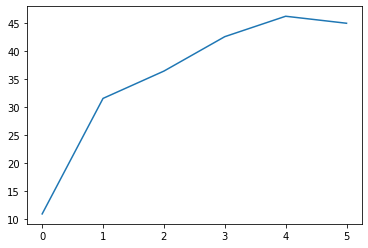

14
14

Power Allocated= 3.2233257655586307
CSI= 0.9659453314730677
SNR= 31.474765549541488
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.161892
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 1.394927
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 1.054009
Model client4 Train Epoch: 4 [0/320 (0%)]	Loss: 0.889649
Model client4 Train Epoch: 5 [0/320 (0%)]	Loss: 0.593770
Model client4 Train Epoch: 6 [0/320 (0%)]	Loss: 0.407262
Model client4 Train Epoch: 7 [0/320 (0%)]	Loss: 0.232724
Model client4 Train Epoch: 8 [0/320 (0%)]	Loss: 0.167468
Model client4 Train Epoch: 9 [0/320 (0%)]	Loss: 0.213474
Model client4 Train Epoch: 10 [0/320 (0%)]	Loss: 0.298975

Power Allocated= 2.603628087889576
CSI= 0.6042467843226621
SNR= 41.4970229940401
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.082902
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 1.419120
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.683197
Model client5 Train Epoch: 4 [0/320 (0%)]	Loss: 0.637

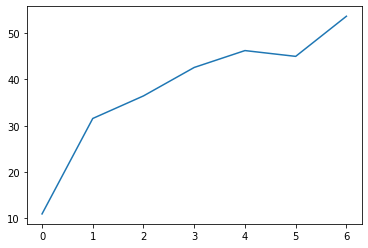

14
14

Power Allocated= 3.2233257655586307
CSI= 0.9659453314730677
SNR= 31.474765549541488
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.083402
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.778418
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.445999
Model client4 Train Epoch: 4 [0/320 (0%)]	Loss: 0.545023
Model client4 Train Epoch: 5 [0/320 (0%)]	Loss: 0.214564
Model client4 Train Epoch: 6 [0/320 (0%)]	Loss: 0.606389
Model client4 Train Epoch: 7 [0/320 (0%)]	Loss: 0.328147
Model client4 Train Epoch: 8 [0/320 (0%)]	Loss: 0.366033
Model client4 Train Epoch: 9 [0/320 (0%)]	Loss: 0.307533
Model client4 Train Epoch: 10 [0/320 (0%)]	Loss: 0.125056

Power Allocated= 2.603628087889576
CSI= 0.6042467843226621
SNR= 41.4970229940401
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.966684
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.847560
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.303522
Model client5 Train Epoch: 4 [0/320 (0%)]	Loss: 0.140

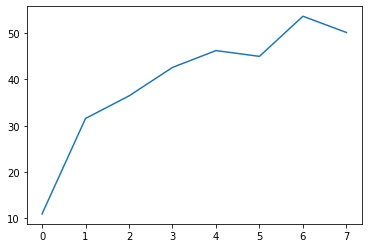

14
14

Power Allocated= 3.2233257655586307
CSI= 0.9659453314730677
SNR= 31.474765549541488
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.031785
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.955576
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.289551
Model client4 Train Epoch: 4 [0/320 (0%)]	Loss: 0.059590
Model client4 Train Epoch: 5 [0/320 (0%)]	Loss: 0.119385
Model client4 Train Epoch: 6 [0/320 (0%)]	Loss: 0.056104
Model client4 Train Epoch: 7 [0/320 (0%)]	Loss: 0.012241
Model client4 Train Epoch: 8 [0/320 (0%)]	Loss: 0.002386
Model client4 Train Epoch: 9 [0/320 (0%)]	Loss: 0.004586
Model client4 Train Epoch: 10 [0/320 (0%)]	Loss: 0.722549

Power Allocated= 2.603628087889576
CSI= 0.6042467843226621
SNR= 41.4970229940401
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.094472
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.743693
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.215874
Model client5 Train Epoch: 4 [0/320 (0%)]	Loss: 0.095

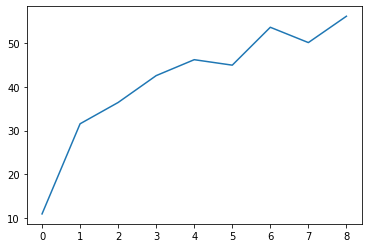

14
14

Power Allocated= 3.2233257655586307
CSI= 0.9659453314730677
SNR= 31.474765549541488
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.778319
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.232030
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.111249
Model client4 Train Epoch: 4 [0/320 (0%)]	Loss: 0.192166
Model client4 Train Epoch: 5 [0/320 (0%)]	Loss: 0.054068
Model client4 Train Epoch: 6 [0/320 (0%)]	Loss: 0.040109
Model client4 Train Epoch: 7 [0/320 (0%)]	Loss: 0.351715
Model client4 Train Epoch: 8 [0/320 (0%)]	Loss: 0.000337
Model client4 Train Epoch: 9 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 10 [0/320 (0%)]	Loss: 0.005874

Power Allocated= 2.603628087889576
CSI= 0.6042467843226621
SNR= 41.4970229940401
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.634916
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.191903
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.074331
Model client5 Train Epoch: 4 [0/320 (0%)]	Loss: 0.072

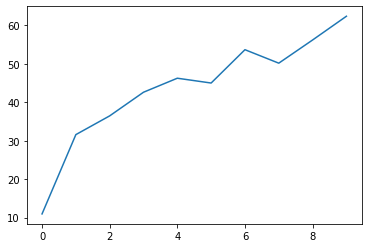

14
14

Power Allocated= 3.2233257655586307
CSI= 0.9659453314730677
SNR= 31.474765549541488
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.734524
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.190888
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.201332
Model client4 Train Epoch: 4 [0/320 (0%)]	Loss: 0.002888
Model client4 Train Epoch: 5 [0/320 (0%)]	Loss: 0.000819
Model client4 Train Epoch: 6 [0/320 (0%)]	Loss: 0.072258
Model client4 Train Epoch: 7 [0/320 (0%)]	Loss: 0.023759
Model client4 Train Epoch: 8 [0/320 (0%)]	Loss: 0.001389
Model client4 Train Epoch: 9 [0/320 (0%)]	Loss: 0.263485
Model client4 Train Epoch: 10 [0/320 (0%)]	Loss: 0.000138

Power Allocated= 2.603628087889576
CSI= 0.6042467843226621
SNR= 41.4970229940401
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.600847
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.170055
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.099806
Model client5 Train Epoch: 4 [0/320 (0%)]	Loss: 0.010

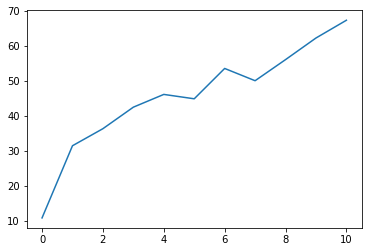

14
14

Power Allocated= 3.2233257655586307
CSI= 0.9659453314730677
SNR= 31.474765549541488
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.773786
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.142232
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.106670
Model client4 Train Epoch: 4 [0/320 (0%)]	Loss: 0.066350
Model client4 Train Epoch: 5 [0/320 (0%)]	Loss: 0.200780
Model client4 Train Epoch: 6 [0/320 (0%)]	Loss: 0.102291
Model client4 Train Epoch: 7 [0/320 (0%)]	Loss: 0.111166
Model client4 Train Epoch: 8 [0/320 (0%)]	Loss: 0.053253
Model client4 Train Epoch: 9 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 10 [0/320 (0%)]	Loss: 0.000039

Power Allocated= 2.603628087889576
CSI= 0.6042467843226621
SNR= 41.4970229940401
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.440357
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.171657
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.006777
Model client5 Train Epoch: 4 [0/320 (0%)]	Loss: 0.006

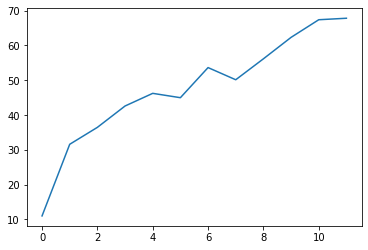

14
14

Power Allocated= 3.2233257655586307
CSI= 0.9659453314730677
SNR= 31.474765549541488
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.555275
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.110707
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.116057
Model client4 Train Epoch: 4 [0/320 (0%)]	Loss: 0.089000
Model client4 Train Epoch: 5 [0/320 (0%)]	Loss: 0.063048
Model client4 Train Epoch: 6 [0/320 (0%)]	Loss: 0.000008
Model client4 Train Epoch: 7 [0/320 (0%)]	Loss: 0.000020
Model client4 Train Epoch: 8 [0/320 (0%)]	Loss: 0.000021
Model client4 Train Epoch: 9 [0/320 (0%)]	Loss: 0.050411
Model client4 Train Epoch: 10 [0/320 (0%)]	Loss: 0.153166

Power Allocated= 2.603628087889576
CSI= 0.6042467843226621
SNR= 41.4970229940401
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.059944
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.076688
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.156745
Model client5 Train Epoch: 4 [0/320 (0%)]	Loss: 0.000

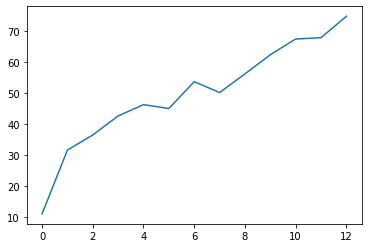

14
14

Power Allocated= 3.2233257655586307
CSI= 0.9659453314730677
SNR= 31.474765549541488
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.560205
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.241223
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.063171
Model client4 Train Epoch: 4 [0/320 (0%)]	Loss: 0.004960
Model client4 Train Epoch: 5 [0/320 (0%)]	Loss: 0.010000
Model client4 Train Epoch: 6 [0/320 (0%)]	Loss: 0.012670
Model client4 Train Epoch: 7 [0/320 (0%)]	Loss: 0.001916
Model client4 Train Epoch: 8 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 9 [0/320 (0%)]	Loss: 0.000001
Model client4 Train Epoch: 10 [0/320 (0%)]	Loss: 0.336207

Power Allocated= 2.603628087889576
CSI= 0.6042467843226621
SNR= 41.4970229940401
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.006645
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.517551
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.565107
Model client5 Train Epoch: 4 [0/320 (0%)]	Loss: 0.133

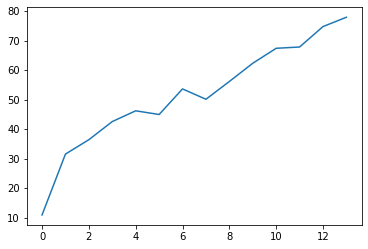

14
14

Power Allocated= 3.2233257655586307
CSI= 0.9659453314730677
SNR= 31.474765549541488
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.515391
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.163926
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.039630
Model client4 Train Epoch: 4 [0/320 (0%)]	Loss: 0.050195
Model client4 Train Epoch: 5 [0/320 (0%)]	Loss: 0.147352
Model client4 Train Epoch: 6 [0/320 (0%)]	Loss: 0.267607
Model client4 Train Epoch: 7 [0/320 (0%)]	Loss: 0.382854
Model client4 Train Epoch: 8 [0/320 (0%)]	Loss: 0.362122
Model client4 Train Epoch: 9 [0/320 (0%)]	Loss: 0.081606
Model client4 Train Epoch: 10 [0/320 (0%)]	Loss: 0.241289

Power Allocated= 2.603628087889576
CSI= 0.6042467843226621
SNR= 41.4970229940401
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.092725
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.251423
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.448436
Model client5 Train Epoch: 4 [0/320 (0%)]	Loss: 0.107

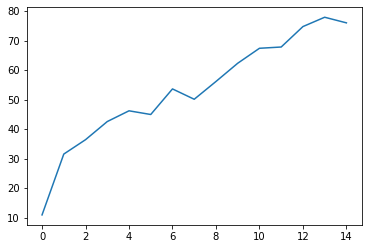

14
14

Power Allocated= 3.2233257655586307
CSI= 0.9659453314730677
SNR= 31.474765549541488
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.447395
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.095101
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.155096
Model client4 Train Epoch: 4 [0/320 (0%)]	Loss: 0.019316
Model client4 Train Epoch: 5 [0/320 (0%)]	Loss: 0.114559
Model client4 Train Epoch: 6 [0/320 (0%)]	Loss: 0.315053
Model client4 Train Epoch: 7 [0/320 (0%)]	Loss: 0.000647
Model client4 Train Epoch: 8 [0/320 (0%)]	Loss: 0.000076
Model client4 Train Epoch: 9 [0/320 (0%)]	Loss: 0.001114
Model client4 Train Epoch: 10 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.603628087889576
CSI= 0.6042467843226621
SNR= 41.4970229940401
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.116832
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.090849
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.170857
Model client5 Train Epoch: 4 [0/320 (0%)]	Loss: 0.266

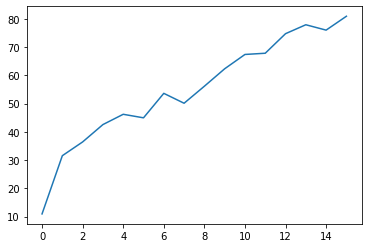

14
14

Power Allocated= 3.2233257655586307
CSI= 0.9659453314730677
SNR= 31.474765549541488
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.103685
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.024874
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.013225
Model client4 Train Epoch: 4 [0/320 (0%)]	Loss: 0.092310
Model client4 Train Epoch: 5 [0/320 (0%)]	Loss: 0.040758
Model client4 Train Epoch: 6 [0/320 (0%)]	Loss: 0.002840
Model client4 Train Epoch: 7 [0/320 (0%)]	Loss: 0.002853
Model client4 Train Epoch: 8 [0/320 (0%)]	Loss: 0.004403
Model client4 Train Epoch: 9 [0/320 (0%)]	Loss: 0.005214
Model client4 Train Epoch: 10 [0/320 (0%)]	Loss: 0.000025

Power Allocated= 2.603628087889576
CSI= 0.6042467843226621
SNR= 41.4970229940401
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 0.908194
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.027092
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.005364
Model client5 Train Epoch: 4 [0/320 (0%)]	Loss: 0.000

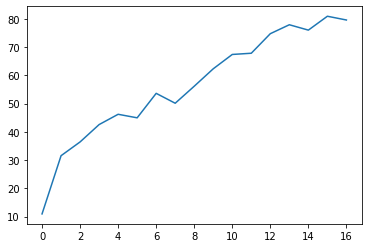

14
14

Power Allocated= 3.2233257655586307
CSI= 0.9659453314730677
SNR= 31.474765549541488
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.219709
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.065408
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.075764
Model client4 Train Epoch: 4 [0/320 (0%)]	Loss: 0.001757
Model client4 Train Epoch: 5 [0/320 (0%)]	Loss: 0.000005
Model client4 Train Epoch: 6 [0/320 (0%)]	Loss: 0.000004
Model client4 Train Epoch: 7 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 8 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 9 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 10 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.603628087889576
CSI= 0.6042467843226621
SNR= 41.4970229940401
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 0.752827
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.018061
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.001152
Model client5 Train Epoch: 4 [0/320 (0%)]	Loss: 0.005

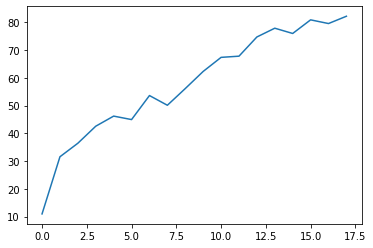

14
14

Power Allocated= 3.2233257655586307
CSI= 0.9659453314730677
SNR= 31.474765549541488
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.221256
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.056399
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.082890
Model client4 Train Epoch: 4 [0/320 (0%)]	Loss: 0.002743
Model client4 Train Epoch: 5 [0/320 (0%)]	Loss: 0.000054
Model client4 Train Epoch: 6 [0/320 (0%)]	Loss: 0.000951
Model client4 Train Epoch: 7 [0/320 (0%)]	Loss: 0.000134
Model client4 Train Epoch: 8 [0/320 (0%)]	Loss: 0.006449
Model client4 Train Epoch: 9 [0/320 (0%)]	Loss: 0.000175
Model client4 Train Epoch: 10 [0/320 (0%)]	Loss: 0.177858

Power Allocated= 2.603628087889576
CSI= 0.6042467843226621
SNR= 41.4970229940401
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 0.703780
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.024335
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000864
Model client5 Train Epoch: 4 [0/320 (0%)]	Loss: 0.000

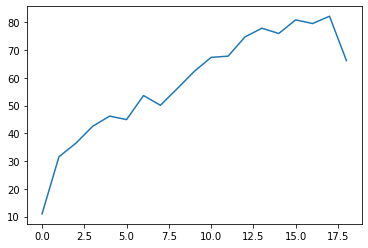

14
14

Power Allocated= 3.2233257655586307
CSI= 0.9659453314730677
SNR= 31.474765549541488
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 0.811254
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.035754
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.127323
Model client4 Train Epoch: 4 [0/320 (0%)]	Loss: 0.051173
Model client4 Train Epoch: 5 [0/320 (0%)]	Loss: 0.001678
Model client4 Train Epoch: 6 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 7 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 8 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 9 [0/320 (0%)]	Loss: 0.000001
Model client4 Train Epoch: 10 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.603628087889576
CSI= 0.6042467843226621
SNR= 41.4970229940401
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 0.562673
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.016387
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.005160
Model client5 Train Epoch: 4 [0/320 (0%)]	Loss: 0.000

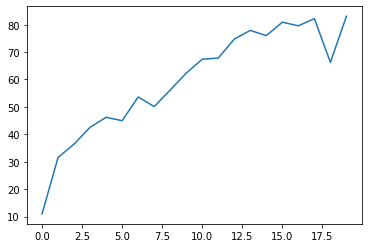

14
14

Power Allocated= 3.2233257655586307
CSI= 0.9659453314730677
SNR= 31.474765549541488
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.078856
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.099126
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.040727
Model client4 Train Epoch: 4 [0/320 (0%)]	Loss: 0.004340
Model client4 Train Epoch: 5 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 6 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 7 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 8 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 9 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 10 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.603628087889576
CSI= 0.6042467843226621
SNR= 41.4970229940401
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 0.627223
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.024351
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.002678
Model client5 Train Epoch: 4 [0/320 (0%)]	Loss: 0.000

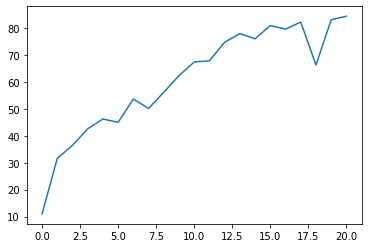

14
14

Power Allocated= 3.2233257655586307
CSI= 0.9659453314730677
SNR= 31.474765549541488
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.158556
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.027631
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.031639
Model client4 Train Epoch: 4 [0/320 (0%)]	Loss: 0.000307
Model client4 Train Epoch: 5 [0/320 (0%)]	Loss: 0.000042
Model client4 Train Epoch: 6 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 7 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 8 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 9 [0/320 (0%)]	Loss: 0.000521
Model client4 Train Epoch: 10 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.603628087889576
CSI= 0.6042467843226621
SNR= 41.4970229940401
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 0.689528
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.008552
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.001095
Model client5 Train Epoch: 4 [0/320 (0%)]	Loss: 0.000

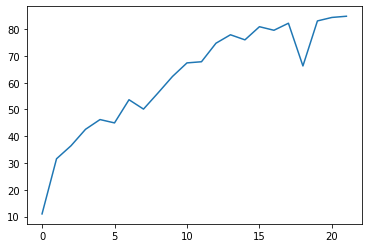

14
14

Power Allocated= 3.2233257655586307
CSI= 0.9659453314730677
SNR= 31.474765549541488
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.207802
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.134535
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.035017
Model client4 Train Epoch: 4 [0/320 (0%)]	Loss: 0.000165
Model client4 Train Epoch: 5 [0/320 (0%)]	Loss: 0.000034
Model client4 Train Epoch: 6 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 7 [0/320 (0%)]	Loss: 0.003853
Model client4 Train Epoch: 8 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 9 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 10 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.603628087889576
CSI= 0.6042467843226621
SNR= 41.4970229940401
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 0.828310
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.016900
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.002071
Model client5 Train Epoch: 4 [0/320 (0%)]	Loss: 0.000

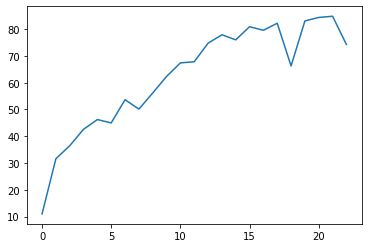

14
14

Power Allocated= 3.2233257655586307
CSI= 0.9659453314730677
SNR= 31.474765549541488
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.219687
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.041791
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.158906
Model client4 Train Epoch: 4 [0/320 (0%)]	Loss: 0.006670
Model client4 Train Epoch: 5 [0/320 (0%)]	Loss: 0.000001
Model client4 Train Epoch: 6 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 7 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 8 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 9 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 10 [0/320 (0%)]	Loss: 0.001204

Power Allocated= 2.603628087889576
CSI= 0.6042467843226621
SNR= 41.4970229940401
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.414600
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.052912
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.008938
Model client5 Train Epoch: 4 [0/320 (0%)]	Loss: 0.006

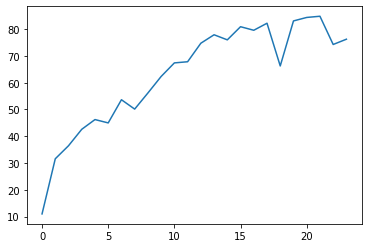

14
14

Power Allocated= 3.2233257655586307
CSI= 0.9659453314730677
SNR= 31.474765549541488
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.200635
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.173900
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.188248
Model client4 Train Epoch: 4 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 5 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 6 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 7 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 8 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 9 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 10 [0/320 (0%)]	Loss: 0.086470

Power Allocated= 2.603628087889576
CSI= 0.6042467843226621
SNR= 41.4970229940401
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.578498
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.067646
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000274
Model client5 Train Epoch: 4 [0/320 (0%)]	Loss: 0.000

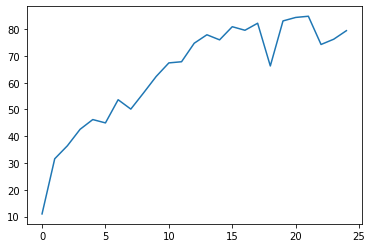

14
14

Power Allocated= 3.2233257655586307
CSI= 0.9659453314730677
SNR= 31.474765549541488
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.332782
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.033911
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000156
Model client4 Train Epoch: 4 [0/320 (0%)]	Loss: 0.119036
Model client4 Train Epoch: 5 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 6 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 7 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 8 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 9 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 10 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.603628087889576
CSI= 0.6042467843226621
SNR= 41.4970229940401
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 0.660254
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.026102
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000836
Model client5 Train Epoch: 4 [0/320 (0%)]	Loss: 0.000

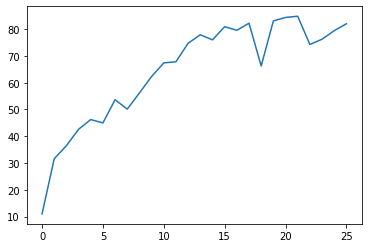

14
14

Power Allocated= 3.2233257655586307
CSI= 0.9659453314730677
SNR= 31.474765549541488
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.156229
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.062285
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.004946
Model client4 Train Epoch: 4 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 5 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 6 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 7 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 8 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 9 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 10 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.603628087889576
CSI= 0.6042467843226621
SNR= 41.4970229940401
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 0.526094
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.037938
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000532
Model client5 Train Epoch: 4 [0/320 (0%)]	Loss: 0.004

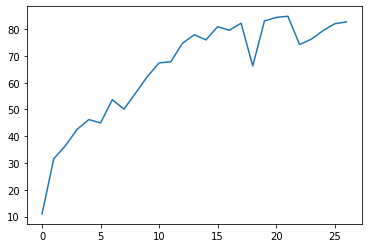

14
14

Power Allocated= 3.2233257655586307
CSI= 0.9659453314730677
SNR= 31.474765549541488
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.083111
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.068887
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.001121
Model client4 Train Epoch: 4 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 5 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 6 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 7 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 8 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 9 [0/320 (0%)]	Loss: 0.000000
Model client4 Train Epoch: 10 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.603628087889576
CSI= 0.6042467843226621
SNR= 41.4970229940401
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 0.361203
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.060446
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000013
Model client5 Train Epoch: 4 [0/320 (0%)]	Loss: 0.000

In [ ]:
for client in clients: #give the model and optimizer to every client
    torch.manual_seed(args.torch_seed)
    client['model'] = Net().to(device)
    #client['model'] = torch.quantization.quantize_dynamic(
    #client['model'],  # the original model
    #{torch.nn.Linear},  # a set of layers to dynamically quantize
    #dtype=torch.fp)  # the target dtype for quantized weights
    client['optim'] = optim.SGD(client['model'].parameters(), lr=args.lr)
    
acc1=[]
acc2=[]
acf=[]
rc=1
temp=[]
snrplot=[]
for fed_round in range(args.rounds):
    overall=Net()
    if(fed_round==0): #fed_round==0
        arranged_clusters=cluster_former()
        temp=copy.deepcopy(arranged_clusters)
    else:
        #print(temp)
        arranged_clusters=copy.deepcopy(temp)
    
    
    
# #     uncomment if you want a random fraction for C every round
# #     args.C = float(format(np.random.random(), '.1f'))
    
#     # number of selected clients
#     m = int(max(args.C * args.clients, 1)) #at least 1 client is selected for training

#     # Selected devices
#     np.random.seed(fed_round)
#     selected_clients_inds = np.random.choice(range(len(clients)), m, replace=False)#dont choose same client more than once
#     selected_clients = [clients[i] for i in selected_clients_inds]
    
#     # Active devices
#     np.random.seed(fed_round)
#     active_clients_inds = np.random.choice(selected_clients_inds, int((1-args.drop_rate) * m), replace=False) #drop clients
#     active_clients = [clients[i] for i in active_clients_inds]
    
    members1=arranged_clusters[0]['Members']
    members2=arranged_clusters[1]['Members']
    print(len(members1))
    print(len(members2))
    new_members1=[]
    new_members2=[]
    
    for ij in members1:
        #print(ij)
        cl_no=int(ij[6:])
        new_members1.append(clients[cl_no-1])
    for ij in members2:
        #print(ij)
        cl_no=int(ij[6:])
        new_members2.append(clients[cl_no-1])
    
    arranged_clusters[0]['Members']=new_members1
    arranged_clusters[1]['Members']=new_members2
    
    cl_no=int(arranged_clusters[0]['Cluster Head'][6:])
    arranged_clusters[0]['Cluster Head']=clients[cl_no-1]
    cl_no=int(arranged_clusters[1]['Cluster Head'][6:])
    arranged_clusters[1]['Cluster Head']=clients[cl_no-1]
        
        
        
    #training members of individual clusters and considering cluster head as the global server for the time slot
    no=1
    
    for cluster in arranged_clusters:  
        client_good_channel=[] #to check which clients have a good channel, only those will be taken for averaging per round
        members=cluster['Members']
        snrlist=cluster['SNR']
        csilist=cluster['CSI']
        head=cluster['Cluster Head']
        snr=[]
        csi=[]
        for i in snrlist:
            snr.append(i[2])
        for i in csilist:
            csi.append(i[2])
        print()
        #print(csi)
        smallmu1=0
        gsmall1=3.402823466E+38 
        
        #water filling algorithm
        mu=1e-15
        while(mu<=1):
            g1=0
            pn1=0
            for jj in csi:
                pn=max(1/mu-1/jj,0)
                g1+=math.log(1+pn*jj) #capacity of a channel (shannon's law)
                pn1+=pn
            g=g1-mu*(pn1-P*30)
            if(g<gsmall1):
                smallmu1=mu
                gsmall1=g
            mu+=0.00002
         
        good_mem=[]

        index=0
        for client in members:
            goodchannel=ClientUpdate(args, device, client,key_np,key,snr[index],csi[index],smallmu1)
            index+=1
            if(goodchannel):
                good_mem.append(client)


        head['model']=averageModels(head['model'], good_mem)
        ac=test(args,head['model'], device, global_test_loader, 'Cluster'+str(no),fed_round)
        no+=1
        # for client in members:
        #     client['model'].load_state_dict(head['model'].state_dict())
        # cluster['Members']=members
        # cluster['Cluster Head']['model'].load_state_dict(head['model'].state_dict())
        
        # if(cluster==arranged_clusters[0]):
        #     acc1.append(ac)
        # elif(cluster==arranged_clusters[1]):
        #     acc2.append(ac)
    
    # if(acc1[-1]>=acc2[-1]):
    #     head=arranged_clusters[0]["Cluster Head"]
    #     index=0
    #     for client in clients:
    #         client['model'].load_state_dict(head['model'].state_dict())
    #         client=CLientReturn(client,snr[index],csi[index],smallmu1)
    #         index+=1
    # else:
    #     head=arranged_clusters[1]["Cluster Head"]
    #     index=0
    #     for client in clients:
    #         client['model'].load_state_dict(head['model'].state_dict())
    #         client=CLientReturn(client,snr[index],csi[index],smallmu1)
    #         index+=1
    # acf.append(test(args,head['model'], device, global_test_loader, "Final",fed_round))


    snrsum1=0
    snrsum2=0
    for k in snrlist:
        if(arranged_clusters[0]["Cluster Head"]['hook'].id in k):
            snrsum1+=k[2]
        else:
            snrsum2+=k[2]
    
    #print(snrsum1,snrsum2)

    weight1=snrsum1/(snrsum1+snrsum2)
    weight2=snrsum2/(snrsum1+snrsum2)
    snrplot.append((snrsum1+snrsum2)/len(snrlist))
    
    head1=arranged_clusters[0]["Cluster Head"]
    head2=arranged_clusters[1]["Cluster Head"]
    
    poptim=2
    snr=snrlist[-1][-1]+10
    csi=csilist[-1][-1]
    print(snr)
    snr__=10**(snr/10)
    absh=csi*poptim/snr__
    x=random.uniform(0,absh)
    y=math.sqrt(absh*absh-x*x)
    std=math.sqrt(poptim/snr__*absh*absh) #channel noise
#     std=random.random()
    h=complex(x,y)
    
    data=head1['model'].conv1.weight
    #data=data.cuda()
    data=data*math.sqrt(poptim) #transmitted signal
    #print(power)
    if(use_cuda):
        data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
    else:
        data=h*data+(torch.randn(data.size())*std)
    data=data/(math.sqrt(poptim)*(h))  #demodulating received data
    data=data.real #demodulating received data
    head1['model'].conv1.weight.data=data



    data=head1['model'].conv2.weight
    #data=data.cuda()
    data=data*math.sqrt(poptim) #transmitted signal
    if(use_cuda):
        data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
    else:
        data=h*data+(torch.randn(data.size())*std)
    data=data/(math.sqrt(poptim)*(h))  #demodulating received data
    data=data.real #demodulating received data
    head1['model'].conv2.weight.data=data
    
    data=head2['model'].conv1.weight
    #data=data.cuda()
    data=data*math.sqrt(poptim) #transmitted signal
    #print(power)
    if(use_cuda):
        data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
    else:
        data=h*data+(torch.randn(data.size())*std)
    data=data/(math.sqrt(poptim)*(h))  #demodulating received data
    data=data.real #demodulating received data
    head2['model'].conv1.weight.data=data



    data=head2['model'].conv2.weight
    #data=data.cuda()
    data=data*math.sqrt(poptim) #transmitted signal
    if(use_cuda):
        data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
    else:
        data=h*data+(torch.randn(data.size())*std)
    data=data/(math.sqrt(poptim)*(h))  #demodulating received data
    data=data.real #demodulating received data
    head2['model'].conv2.weight.data=data
    
    overall=averageModelscluster(overall,[head1,head2],[weight1,weight2])
    acf.append(test(args,overall, device, global_test_loader, "Final ",fed_round))
    index=0
    # for client in clients:
    #     client['model'].load_state_dict(overall.state_dict())
    #     client=CLientReturn(client,snr[index],csi[index],smallmu1)
    #     index+=1
    for client in clients:
        client['model'].load_state_dict(overall.state_dict())
        #client=CLientReturn(client,snr[index],csi[index],smallmu1)  #CHANGE: commented
        index+=1





    print(rc)
    rc+=1
    
    fig,ax=plt.subplots()
    ax.plot([i for i in range(len(acf))],acf)
    plt.show()
plt.show()
#plt.savefig('result_cluster.png')

In [ ]:
print(acf)
print(snrplot)